# Projet 2 : Concevez une application au service de la santé publique

Les données utilisées dans le cadre de ce projet sont issues du projet Open Food Facts. C'est un projet a but non lucratif développé par des volontaires visant à créer une base de données sur des produits alimentaires. Plus d'informations à cette addresse : https://world.openfoodfacts.org/discover. Nous allons utiliser ces données pour voir si on peut prédire le nutriscore d'un produit à partir de ses caractéristiques nutritives.

## Notebook 1 : Nettoyage des données
Ce notebook est un travail préparatoire à l'analyse de données. Il faut dans un premier temps sélectionner les données exploitables en fonction de l'objet de l'étude. Cela implique une première visualisation des données manquantes. Ensuite, il est nécessaire de retirer les valeurs aberrantes. Pour cela, il faut garder un regard critique sur la sélection des données. Ce travail est effectué selon le plan suivant :
* Pré-visualisation des valeurs manquantes
* Pré-visualisation des données
* Nettoyage des données basé sur la connaissance métier
* Nettoyage des données statistiques

## Pré-visualisation des valeurs manquantes

Afin de nettoyer les données nous avons besoin des librairies suivantes pour charger et visualiser les données.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import missingno as msno

Les données ont été récupérées à l'addresse suivante : https://static.openfoodfacts.org/data/en.openfoodfacts.org.products.csv 

Premièrement on effectue une lecture de quelques lignes afin de voir l'ensemble des variables disponibles.

In [2]:
df_slice = pd.read_csv('data/en.openfoodfacts.org.products.csv', sep='\t', nrows=10)
columns_list = df_slice.columns
df_quality = pd.Series(index=columns_list, dtype=int)
df_slice.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,generic_name,quantity,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,17,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15T10:38:00Z,1561463718,2019-06-25T11:55:18Z,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13T21:06:14Z,1539464817,2018-10-13T21:06:57Z,Cacao,NaN,130 g,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19T15:02:16Z,1574175737,2019-11-19T15:02:17Z,Filetes de pollo empanado,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,100,http://world-en.openfoodfacts.org/product/0000...,del51,1444572561,2015-10-11T14:09:21Z,1444659212,2015-10-12T14:13:32Z,moutarde au moût de raisin,NaN,100g,...,NaN,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1111111111,http://world-en.openfoodfacts.org/product/0000...,openfoodfacts-contributors,1560020173,2019-06-08T18:56:13Z,1560020173,2019-06-08T18:56:13Z,Sfiudwx,NaN,dgesc,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Pour chaque produit il y a 181 variables caractéristiques. Cependant toutes ces variables ne sont pas forcément renseignées. Nous allons maintenant regarder la qualité des données. Dans un premier temps on va compter le nombre de valeurs manquantes. 

La taille du fichier étant importante environ 3 Go une lecture de l'ensemble du fichier n'est pas possible lorsqu'on dispose de peu de mémoire. Il vaut mieux faire une lecture par partie en utilisant le paramètre chunksize de la fonction read_csv() de la librairie pandas. Pour chaque variable on va compter le nombre d'entrée non manquante.

In [3]:
nb_rows = 0
df_chunk = pd.read_csv('data/en.openfoodfacts.org.products.csv', sep='\t', chunksize=10**4, low_memory=False)

for chunk in df_chunk:
    df_quality += chunk.notna().sum()
    nb_rows = nb_rows + len(chunk)

On peut maintenant calculer le pourcentage de valeur non manquantes. On affiche les variables ayant au moins 10 % de valeur non manquantes.

In [4]:
df_quality_percent = df_quality / nb_rows
mask = df_quality_percent > 0.1
df_interest = df_quality_percent.loc[mask]
pd.set_option('display.max_rows', None)
print(df_interest)
pd.set_option('display.max_rows', 10)

code                                       1.000000
url                                        1.000000
creator                                    0.999997
created_t                                  1.000000
created_datetime                           1.000000
last_modified_t                            1.000000
last_modified_datetime                     1.000000
product_name                               0.954576
quantity                                   0.285161
packaging                                  0.159308
packaging_tags                             0.159300
brands                                     0.557045
brands_tags                                0.557009
categories                                 0.518688
categories_tags                            0.518685
categories_en                              0.518685
labels                                     0.235727
labels_tags                                0.235744
labels_en                                  0.235744
stores      

A partir de cette liste de variable on sélectionne celles qui semblent pertinantes pour la suite de l'étude. On fait le choix de s'intéresser aux nutriments et score des produits. On sélectionne les variables suivantes :

In [5]:
# colonnes importantes :        
columns_list = ['product_name', 'countries_en', 'additives_n', 'ingredients_from_palm_oil_n', 'ingredients_that_may_be_from_palm_oil_n',
                'nutriscore_score', 'nutriscore_grade', 'nova_group', 'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'trans-fat_100g', 'cholesterol_100g', 
                'carbohydrates_100g', 'sugars_100g', 'fiber_100g', 'proteins_100g', 'salt_100g', 'sodium_100g', 'vitamin-a_100g', 'vitamin-c_100g', 'calcium_100g', 'iron_100g', 'nutrition-score-fr_100g']



df = pd.read_csv('data/en.openfoodfacts.org.products.csv', sep='\t', usecols=columns_list)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1403851 entries, 0 to 1403850
Data columns (total 24 columns):
 #   Column                                   Non-Null Count    Dtype  
---  ------                                   --------------    -----  
 0   product_name                             1340083 non-null  object 
 1   countries_en                             1401644 non-null  object 
 2   additives_n                              632307 non-null   float64
 3   ingredients_from_palm_oil_n              632307 non-null   float64
 4   ingredients_that_may_be_from_palm_oil_n  632307 non-null   float64
 5   nutriscore_score                         571098 non-null   float64
 6   nutriscore_grade                         571098 non-null   object 
 7   nova_group                               548308 non-null   float64
 8   energy-kcal_100g                         1063532 non-null  float64
 9   fat_100g                                 1125630 non-null  float64
 10  saturated-fat_100g

A l'aide de la librairie missingno on va visualiser les valeurs manquantes

<AxesSubplot:>

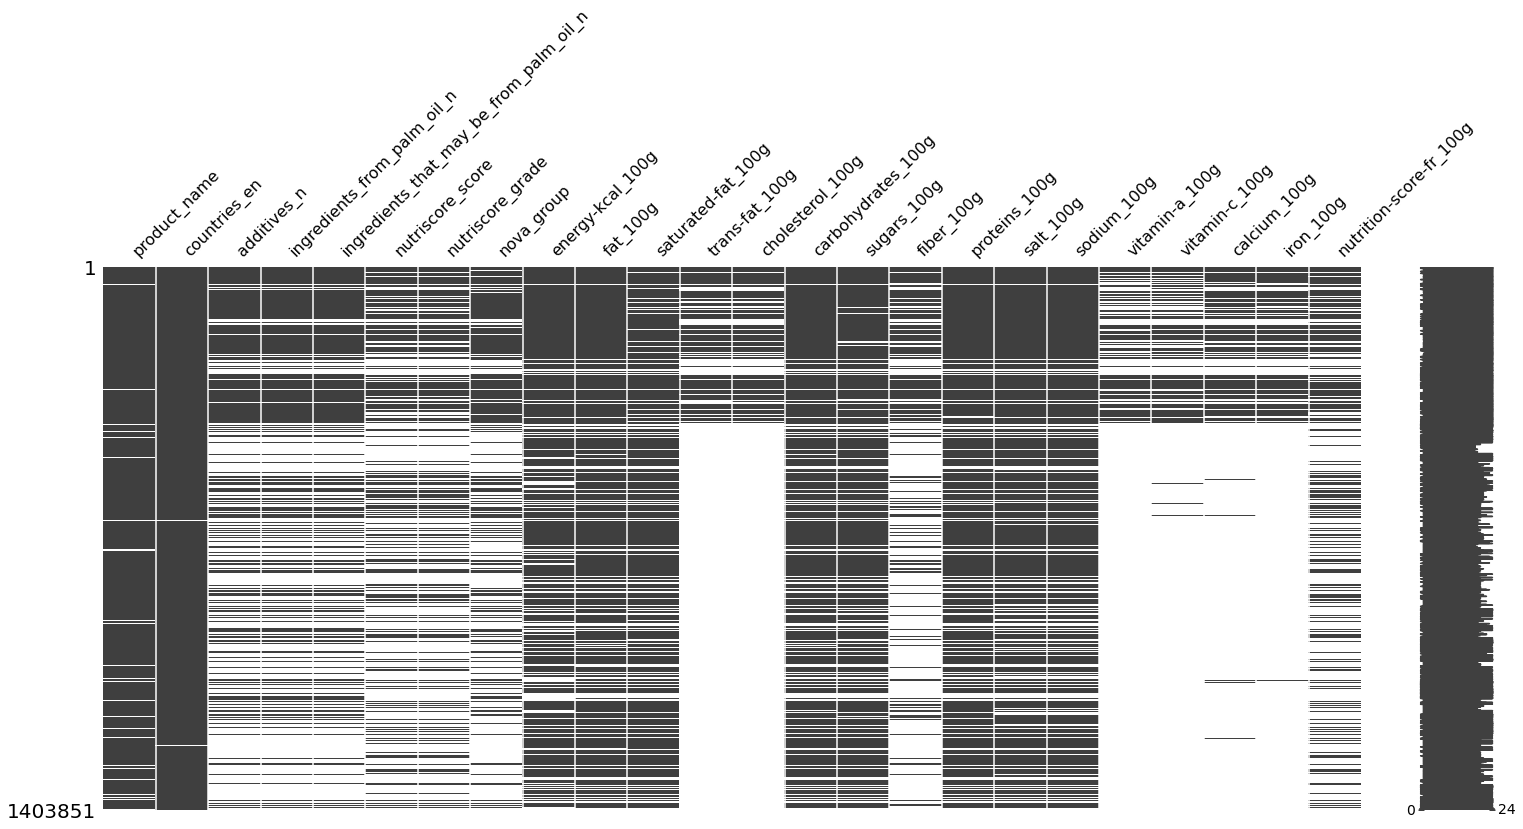

In [6]:
msno.matrix(df)

On constate que les trous de données dépendent des variables. Les variables nom et pays sont quasiment complètes alors que les variables sur les vitamines sont très incomplètes. On s'intéresse ensuite à la corrélation des trous de données.

<AxesSubplot:>

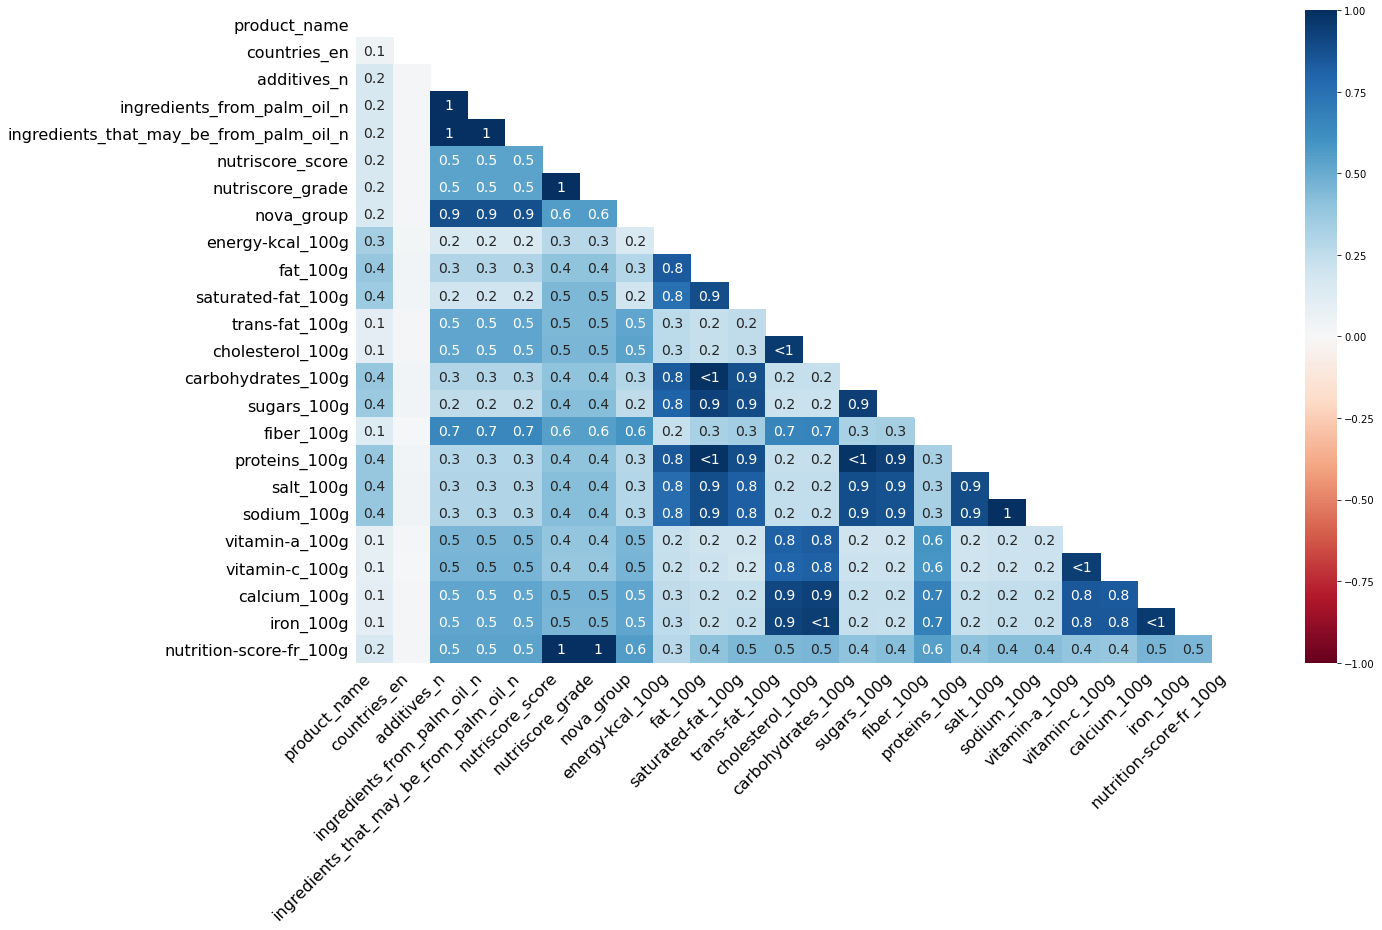

In [7]:
msno.heatmap(df)

Ce graphique permet de voir que l'indice de corrélation entre les variables. On constate qu'il est supérieur à 0,8 entre les variables des nutriments énergétiques (fat_100g, saturated-fat_100g, carbohydrates_100g, sugars_100g, proteins_100g). Cela signifie que lorsque l'une des variables est renseignée les autres le sont généralement aussi. Cela donne du sens à faire l'étude sur ces variables.

Le graphique ci-dessous montre le nombre d'entrées pour chaque variable.

<AxesSubplot:>

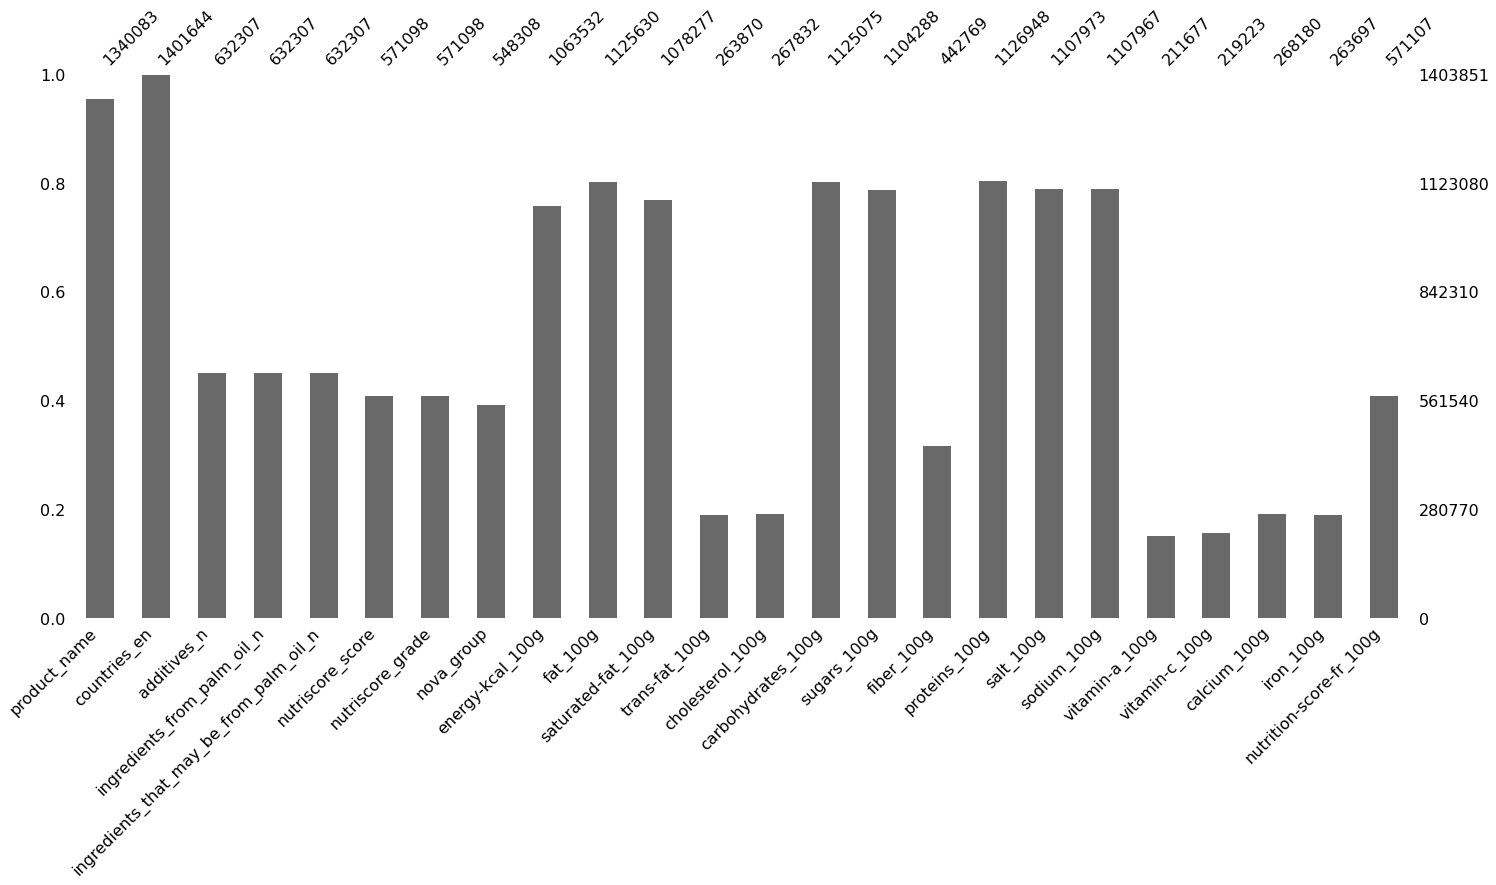

In [8]:
msno.bar(df)

## Pré-visualisation des données

Nous allons maintenant regarder les données pour avoir une idée de la qualité des données renseignées. Ce travail permet de voir si il y a des données aberrantes et définir les filtres à appliquer sur les données.

### VARIABLES CATEGORIQUES

In [9]:
df.loc[:,'countries_en'].value_counts()

France                                                625573
United States                                         323636
Spain                                                 153409
Belgium                                                36809
Germany                                                35864
                                                       ...  
Australia,Belgium,France,Germany,Italy,Switzerland         1
France,Italy,New Zealand,Singapore                         1
Thailand,Vietnam                                           1
Australia,France,Luxembourg                                1
Nederland                                                  1
Name: countries_en, Length: 3154, dtype: int64

On constate qu'il y a des produits renseignés avec plusieurs pays.

### VARIABLES NUMERIQUES

#### Variables discrètes

In [10]:
df.loc[:,'additives_n'].value_counts()

0.0     265446
1.0     112639
2.0      71164
3.0      50150
4.0      37273
         ...  
31.0         5
30.0         4
32.0         2
38.0         2
35.0         1
Name: additives_n, Length: 35, dtype: int64

Les produits renseignés possèdent entre 0 et 35 additifs.

In [11]:
df.loc[:,'ingredients_from_palm_oil_n'].value_counts()

0.0    619314
1.0     12826
2.0       166
3.0         1
Name: ingredients_from_palm_oil_n, dtype: int64

Il y a 13 000 produits sur 85 000 produits renseigné comme ayant un ingrédient à base d'huile de palme.

In [12]:
df.loc[:,'ingredients_that_may_be_from_palm_oil_n'].value_counts()

0.0    594917
1.0     32050
2.0      4226
3.0       878
4.0       208
5.0        26
6.0         2
Name: ingredients_that_may_be_from_palm_oil_n, dtype: int64

Cependant cette proportion passe à 37 000 produits sur 97 000 produits si l'on considère les ingrédients pouvant venir de l'huile de palme.

Le Nutri-score est un indicateur permettant de classer un produit comme bon ou mauvais pour la santé selon ses qualités nutritives. Le score varie entre -15 à 40. Les produits produits ayant le score le plus faible sont considérés comme meilleur pour la santé. 

source https://fr.openfoodfacts.org/nutriscore

<AxesSubplot:>

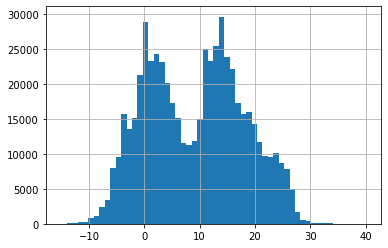

In [13]:
df.loc[:,'nutriscore_score'].hist(bins=56)

Les variables nutriscore_score et nutrition-score-fr_100g semblent être pratiquement identiques car le nombre d'égalités entre les deux variables est pratiquement le nombre de variable non nulle pour ces deux variables.

In [14]:
test_equal = df.loc[:,'nutrition-score-fr_100g'] == df.loc[:,'nutriscore_score']
nb_equal = test_equal.sum()
nb_notna_nutriscore_score = df.loc[:,'nutriscore_score'].notna().sum()
nb_notna_nutrition_score_fr_100g = df.loc[:,'nutrition-score-fr_100g'].notna().sum()

print(f'nb_equal : {nb_equal}')
print(f'nb_notna_nutriscore_score : {nb_notna_nutriscore_score}')
print(f'nb_notna_nutrition-score-fr_100g : {nb_notna_nutrition_score_fr_100g}')


nb_equal : 571098
nb_notna_nutriscore_score : 571098
nb_notna_nutrition-score-fr_100g : 571107


La variable nutriscore_grade correspond à la note associée à un nutri-score. La note est une lettre allant de A jusqu'à E, du meilleur pour la santé au plus mauvais.

source https://fr.openfoodfacts.org/nutriscore

In [15]:
df.loc[:,'nutriscore_grade'].value_counts()

d    176762
c    119503
e    108813
a     92580
b     73440
Name: nutriscore_grade, dtype: int64

La variable nova_group exprime le degré de transformation d'un produit selon la classification NOVA.
Cette classification est composée de 4 groupes d'aliments : 

- 1 : Aliments peu ou non transformés
- 2 : Ingrédients culinaires
- 3 : Aliments transformés
- 4 : Aliments ultra-transformés


source https://fr.wikipedia.org/wiki/NOVA_(nutrition)

In [16]:
df.loc[:,'nova_group'].value_counts()

4.0    366344
3.0    114346
1.0     57135
2.0     10483
Name: nova_group, dtype: int64

### Variables continues

Afin de déterminer la présence de valeurs aberrantes on affiche pour chaque variable les valeurs min max moyenne et écart type

In [17]:
df.loc[:,['energy-kcal_100g','fat_100g','saturated-fat_100g','trans-fat_100g','cholesterol_100g']].describe()

,energy-kcal_100g,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g
count,1.063532e+06,1.125630e+06,1.078277e+06,263870.000000,267832.000000
mean,8.174790e+06,1.388327e+01,1.261272e+08,0.046627,0.046667
std,8.430185e+09,1.772280e+02,1.309706e+11,1.062339,1.455497
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
25%,1.020000e+02,6.000000e-01,1.000000e-01,0.000000,0.000000
50%,2.650000e+02,6.900000e+00,1.900000e+00,0.000000,0.000000
75%,4.000000e+02,2.143000e+01,7.300000e+00,0.000000,0.022000
max,8.693855e+12,1.536795e+05,1.360000e+14,369.000000,300.000000


In [18]:
df.loc[:,['carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g']].describe()

,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g
count,1.125075e+06,1.104288e+06,442769.000000,1.126948e+06
mean,2.860550e+01,1.395176e+01,2.952063,8.496510e+00
std,2.933668e+01,2.072722e+01,6.273939,3.704438e+01
min,0.000000e+00,-1.000000e+00,-20.000000,-5.000000e+02
25%,3.570000e+00,7.000000e-01,0.000000,1.200000e+00
50%,1.580000e+01,3.900000e+00,1.500000,5.800000e+00
75%,5.385000e+01,2.000000e+01,3.600000,1.200000e+01
max,4.800000e+03,4.800000e+03,2020.000000,3.100000e+04


In [19]:
df.loc[:,['salt_100g','sodium_100g','vitamin-a_100g','vitamin-c_100g','calcium_100g','iron_100g']].describe()

,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g
count,1.107973e+06,1.107967e+06,211677.000000,219223.000000,268180.000000,263697.000000
mean,2.114066e+00,8.457045e-01,0.003522,0.024635,0.160895,0.006139
std,1.430553e+02,5.722269e+01,0.505031,0.758521,4.636854,0.261142
min,0.000000e+00,0.000000e+00,-0.000340,0.000000,0.000000,-0.000260
25%,6.000000e-02,2.400000e-02,0.000000,0.000000,0.000000,0.000000
50%,5.300000e-01,2.120000e-01,0.000000,0.000000,0.036000,0.000990
75%,1.350000e+00,5.400000e-01,0.000107,0.004000,0.108000,0.002400
max,1.050000e+05,4.200000e+04,126.000000,100.000000,930.000000,50.000000


On constate que les valeurs max sont très éloignées de la moyenne et parfois n'ont pas de sens physique. Par exemple il y a des valeur supérieures à 100 sur des variables mesurant la quantité pour 100g. Il y a aussi des valeurs négatives ce qui n'a pas de sens physique. Il y a donc des valeurs aberrantes.

## Nettoyage des données basé sur la connaissance métier

Nous avons vu dans la partie précédente qu'il y avait des valeurs aberrantes. Le premier filtre que l'on va appliquer est de supprimer les doublons. Par exemple si un produit a été renseigné plusieurs fois nous allons garder une seule ligne dans le dataframe.

In [20]:
df_metier = df.copy()
nb_lignes_avant_traitement = len(df_metier)
print(f'Nombre de lignes : {nb_lignes_avant_traitement}')
df_metier.drop_duplicates(keep='first', inplace=True)
nb_lignes_apres_doublons = len(df_metier)
nb_lignes_drop = nb_lignes_avant_traitement - nb_lignes_apres_doublons
print(f'Nombre de lignes après avoir retiré les doublons : {nb_lignes_apres_doublons}')
print(f'Nombre de lignes enlevées : {nb_lignes_drop}')

Nombre de lignes : 1403851
Nombre de lignes après avoir retiré les doublons : 1263136
Nombre de lignes enlevées : 140715


### Variables continues

Ensuite on effectue un nettoyage simple basé sur une limite minimum et une limite maximum. La fonction ci-dessous permet d'enlever les lignes du dataframe lorsque pour une colonne donnée la valeur dépasse la valeur limite

In [21]:
def removeOutlier(df, col, min_value, max_value):
    mask = (df.loc[:,col] >= max_value) | (df.loc[:,col] <= min_value)
    index_to_drop = df.index[mask]
    df.drop(index=index_to_drop, inplace=True)

#### Variable : energy-kcal_100g

La quantité d'énergie contenue dans un aliment dépend des types de nutriments. La graisse est la forme qui contient le plus d'énergie avec 9 kcal/g. Un aliment ne peut donc dépasser 900 kcal/100g. On va donc effectuer un premier filtre sur les données avec une limite max à 900 et une limite min à 0.

In [22]:
removeOutlier(df_metier, 'energy-kcal_100g', 0, 900)

In [23]:
df_metier.loc[:,'energy-kcal_100g'].describe()

count    9.772780e+05
mean     2.781020e+02
std      1.822897e+02
min      1.000000e-09
25%      1.120000e+02
50%      2.740000e+02
75%      4.010000e+02
max      8.995500e+02
Name: energy-kcal_100g, dtype: float64

On applique également cette fonction à toutes les variables de quantité qui ne peuvent pas être supérieures à 100g. 

In [24]:
for col in ['fat_100g','saturated-fat_100g','trans-fat_100g','cholesterol_100g']:
    removeOutlier(df_metier, col, 0, 100)

In [25]:
df_metier.loc[:,['fat_100g','saturated-fat_100g','trans-fat_100g','cholesterol_100g']].describe()

,fat_100g,saturated-fat_100g,trans-fat_100g,cholesterol_100g
count,6.595570e+05,6.512490e+05,4075.000000,7865.000000
mean,1.580724e+01,6.159333e+00,1.182454,0.311276
std,1.660913e+01,7.960790e+00,2.371096,4.054627
min,1.000000e-09,1.000000e-10,0.000100,0.000004
25%,2.800000e+00,8.000000e-01,0.260000,0.021000
50%,1.080000e+01,2.900000e+00,0.510000,0.050000
75%,2.419000e+01,9.000000e+00,1.190000,0.071000
max,9.999000e+01,9.990000e+01,50.200000,97.900000


In [26]:
for col in ['carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g']:
    removeOutlier(df_metier, col, 0, 100)

In [27]:
df_metier.loc[:,['carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g']].describe()

,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g
count,5.734890e+05,5.689910e+05,122964.000000,5.745190e+05
mean,2.985491e+01,1.350772e+01,4.054862,9.558140e+00
std,2.658957e+01,1.804920e+01,5.186062,9.552815e+00
min,1.000000e-09,1.000000e-10,0.000004,1.000000e-07
25%,4.800000e+00,1.200000e+00,1.300000,3.500000e+00
50%,2.060000e+01,4.000000e+00,2.600000,7.000000e+00
75%,5.400000e+01,2.100000e+01,5.000000,1.260000e+01
max,9.996000e+01,9.990000e+01,91.800000,9.700000e+01


In [28]:
for col in ['salt_100g','sodium_100g','vitamin-a_100g','vitamin-c_100g','calcium_100g','iron_100g']:
    removeOutlier(df_metier, col, 0, 100)

In [29]:
df_metier.loc[:,['salt_100g','sodium_100g','vitamin-a_100g','vitamin-c_100g','calcium_100g','iron_100g']].describe()

,salt_100g,sodium_100g,vitamin-a_100g,vitamin-c_100g,calcium_100g,iron_100g
count,5.278970e+05,5.278950e+05,2.750000e+03,2.987000e+03,8.223000e+03,5.285000e+03
mean,1.290589e+00,5.162538e-01,7.729685e-02,3.904629e-01,4.279007e-01,8.410340e-02
std,3.615577e+00,1.446399e+00,1.867442e+00,4.038215e+00,3.835716e+00,1.098604e+00
min,7.200000e-09,2.900000e-09,1.000000e-08,3.000000e-09,3.000000e-07,5.000000e-07
25%,1.400000e-01,5.600000e-02,6.825000e-05,3.100000e-03,7.400000e-02,1.090000e-03
50%,7.100000e-01,2.840000e-01,1.400000e-04,1.200000e-02,1.200000e-01,2.410000e-03
75%,1.400000e+00,5.600000e-01,3.981000e-04,3.000000e-02,1.980000e-01,6.000000e-03
max,9.990582e+01,3.996233e+01,7.300000e+01,8.700000e+01,9.850000e+01,4.890000e+01


## Nettoyage des données statistiques

Enfin, nous allons filtrer les données grâce à des méthodes statistiques. Cela permet d'éliminer les valeurs outliers qui sont soit des données aberrantes ou bien des données peu représentatives car très éloignées de la norme.

In [30]:
from scipy.stats import iqr

In [31]:
df_stats = df_metier.copy()

Prenons l'exemple de la variable energy-kcal_100g. Voici l'histogramme de cette variable après avoir retiré les doublons et les valeurs dépassant les limites min et max.

/home/hugo/anaconda3/envs/projet2/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='energy-kcal_100g'>

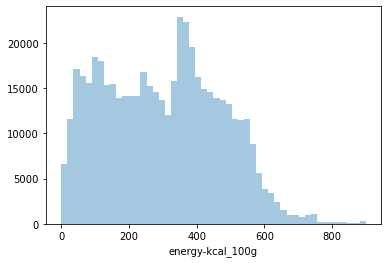

In [32]:
sns.distplot(df_stats.loc[:,'energy-kcal_100g'], kde=False)

On va utiliser l'écart interquartile et la médiane afin de définir des valeurs seuils pour filtrer les outliers. On considère comme outlier une valeur supérieur au seuil médiane + 1,5 x écart interquartile ou alors inférieur au seuil médiane - 1,5 x écart interquartile.

In [33]:
interquartile = iqr(df_stats.loc[:,'energy-kcal_100g'], nan_policy='omit')
print(f'interquartile : {interquartile}')
mediane = np.nanmedian(df_stats.loc[:,'energy-kcal_100g'])
#df_stats.loc[:,'energy-kcal_100g'].median()
print(f'mediane : {mediane}')

interquartile : 279.0
mediane : 302.0


On peut calculer les valeurs seuils.

In [34]:
lim_min = mediane - 1.5 * interquartile
lim_max = mediane + 1.5 * interquartile

On applique le filtre pour les valeurs seuils lim_min et lim_max.

In [35]:
removeOutlier(df_stats, 'energy-kcal_100g', lim_min, lim_max)

Voici le résultat du nettoyage des données avant traitement, après traitement métier et après traitement statistique.

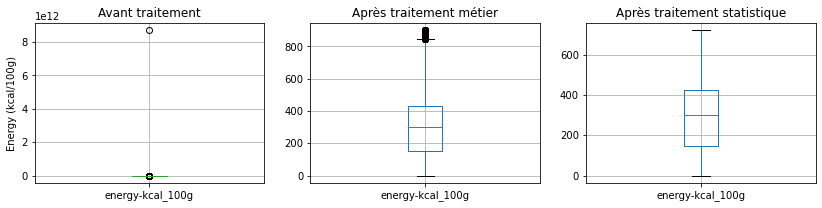

In [36]:
plt.figure(3, figsize=(14, 10))
plt.subplot(331)
df.boxplot(column='energy-kcal_100g')
plt.title('Avant traitement')
plt.ylabel('Energy (kcal/100g)')

plt.subplot(332)
df_metier.boxplot(column='energy-kcal_100g')
plt.title('Après traitement métier')

plt.subplot(333)
df_stats.boxplot(column='energy-kcal_100g')
plt.title('Après traitement statistique')
plt.show()

On peut maintenant automatiser ces étapes par des fonctions. La fonction removeOutlierStats pour enlever les valeurs en dehors de 1,5 fois l'interquartile. 

In [37]:
def removeOutlierStats(col):
    interquartile = iqr(df_stats.loc[:,col], nan_policy='omit')
    mediane = np.nanmedian(df_stats.loc[:,col])
    lim_min = mediane - 1.5 * interquartile
    lim_max = mediane + 1.5 * interquartile
    removeOutlier(df_stats, col, lim_min, lim_max)

La fonction plotTraitement permet de faire un subplot avec un boxplot pour chaque étape du traitement. 

In [38]:
def plotTraitement(col, unit):
    plt.figure(3, figsize=(14, 10))
    plt.subplot(331)
    df.boxplot(column=col)
    plt.title('Avant traitement')
    plt.ylabel(unit)

    plt.subplot(332)
    df_metier.boxplot(column=col)
    plt.title('Après traitement métier')

    plt.subplot(333)
    df_stats.boxplot(column=col)
    plt.title('Après traitement statistique')
    plt.tight_layout()
    plt.show()

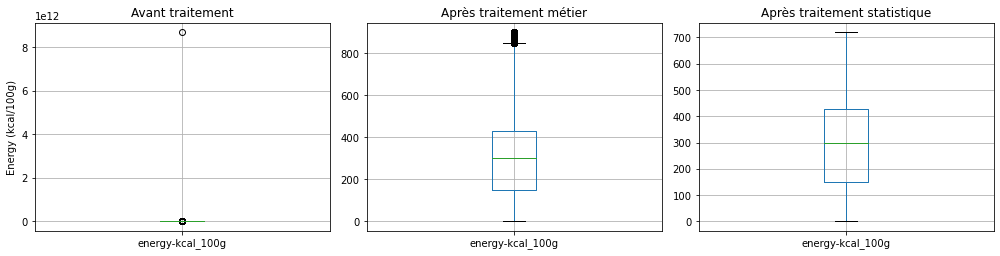

In [39]:
plotTraitement('energy-kcal_100g','Energy (kcal/100g)')

On peut également faire cette fonction avec des violin plot dont la forme tient compte de la distribution.

In [40]:
def plotTraitementViolin(col, unit):
    plt.figure(3, figsize=(14, 10))
    plt.subplot(331)
    sns.violinplot(y=col, data=df)
    plt.title('Avant traitement')
    plt.ylabel(unit)
    plt.xlabel(col)

    plt.subplot(332)
    sns.violinplot(y=col, data=df_metier)
    plt.title('Après traitement métier')
    plt.ylabel(unit)
    plt.xlabel(col)

    plt.subplot(333)
    sns.violinplot(y=col, data=df_stats)
    plt.title('Après traitement statistique')
    plt.ylabel(unit)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

On peut alors lancer le traitement statistique et la visualisation de manière automatisé pour l'ensemble des variables.

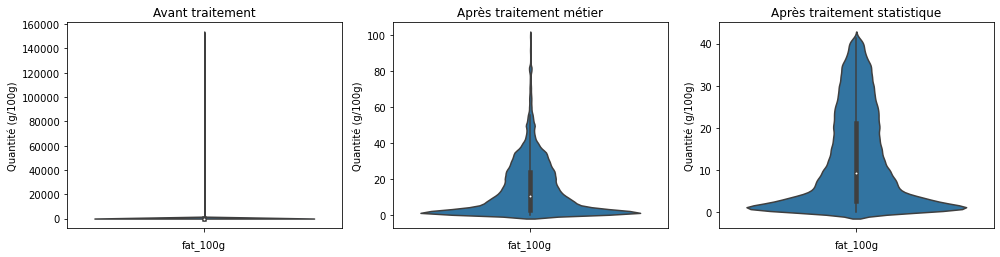

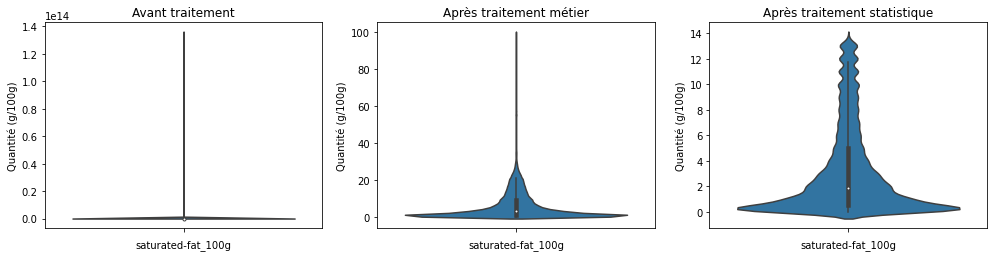

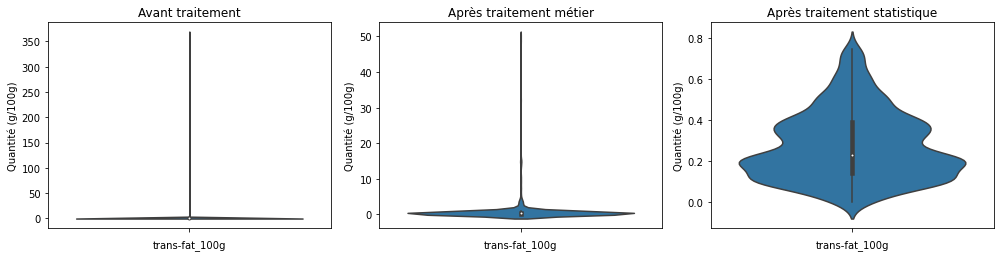

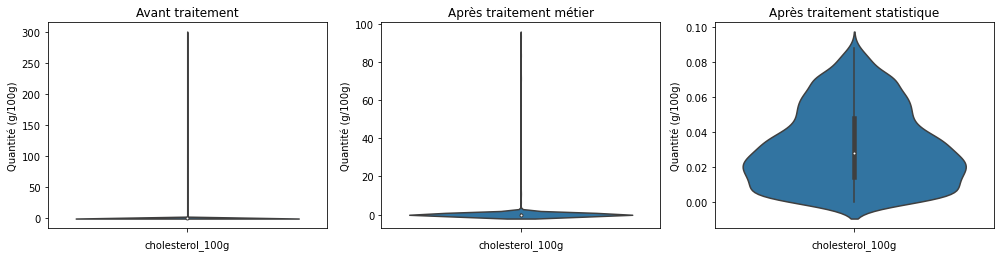

In [41]:
for col in ['fat_100g','saturated-fat_100g','trans-fat_100g','cholesterol_100g']:
    removeOutlierStats(col)
    plotTraitementViolin(col,'Quantité (g/100g)')

On constate que des valeurs inférieurs à 100 g très éloignées de la médiane étaient présentes avant le traitement statistique. On affiche enfin l'histogramme de chaque variable après traitement statistique.

array([[<AxesSubplot:title={'center':'fat_100g'}>,
        <AxesSubplot:title={'center':'saturated-fat_100g'}>],
       [<AxesSubplot:title={'center':'trans-fat_100g'}>,
        <AxesSubplot:title={'center':'cholesterol_100g'}>]], dtype=object)

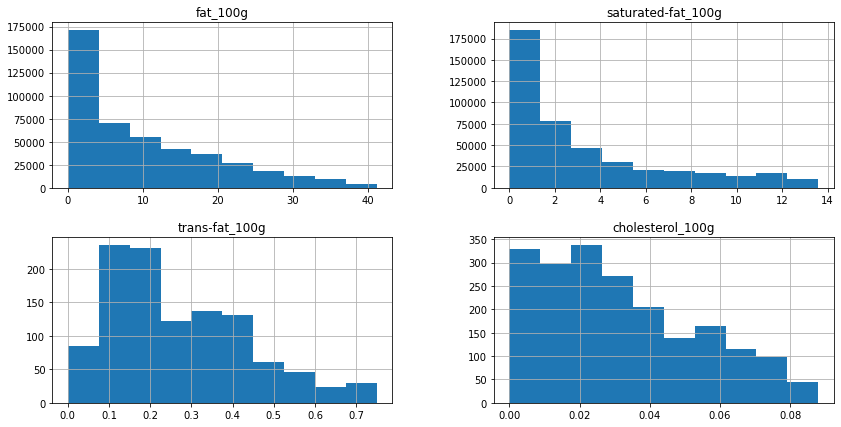

In [42]:
df_stats.loc[:,['fat_100g','saturated-fat_100g','trans-fat_100g','cholesterol_100g']].hist(figsize=(14, 7))

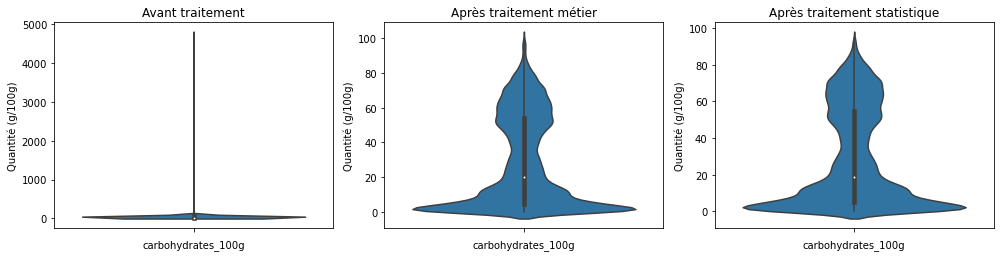

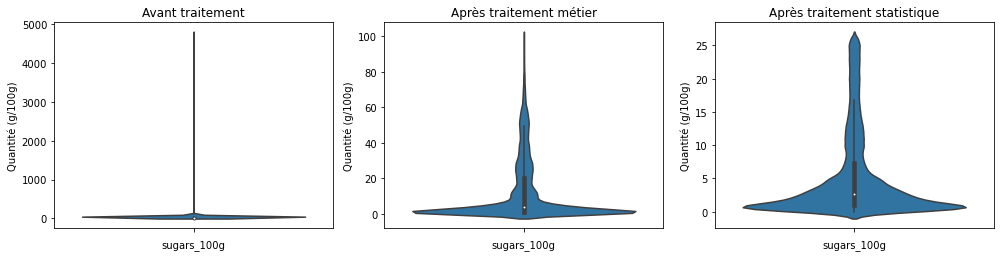

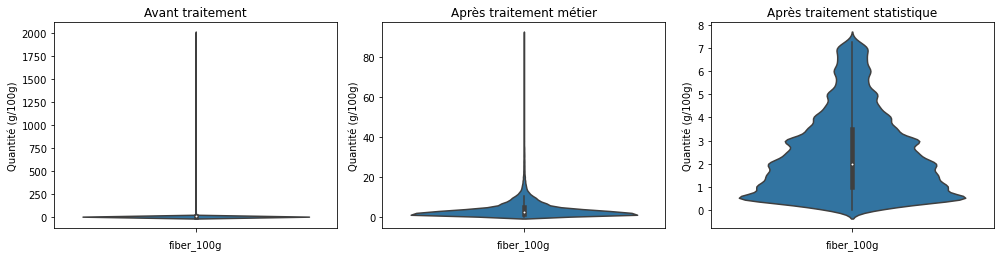

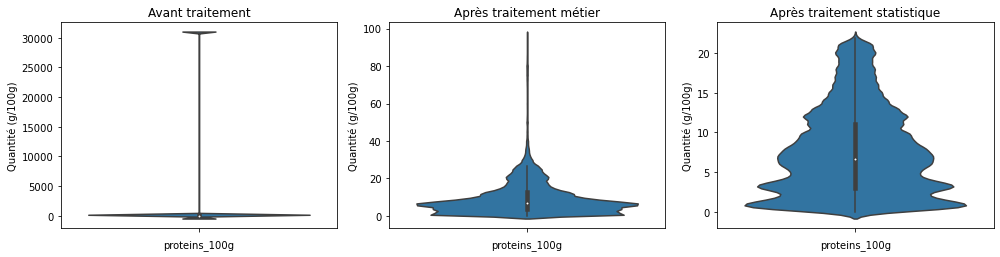

In [43]:
for col in ['carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g']:
    removeOutlierStats(col)
    plotTraitementViolin(col,'Quantité (g/100g)')

array([[<AxesSubplot:title={'center':'carbohydrates_100g'}>,
        <AxesSubplot:title={'center':'sugars_100g'}>],
       [<AxesSubplot:title={'center':'fiber_100g'}>,
        <AxesSubplot:title={'center':'proteins_100g'}>]], dtype=object)

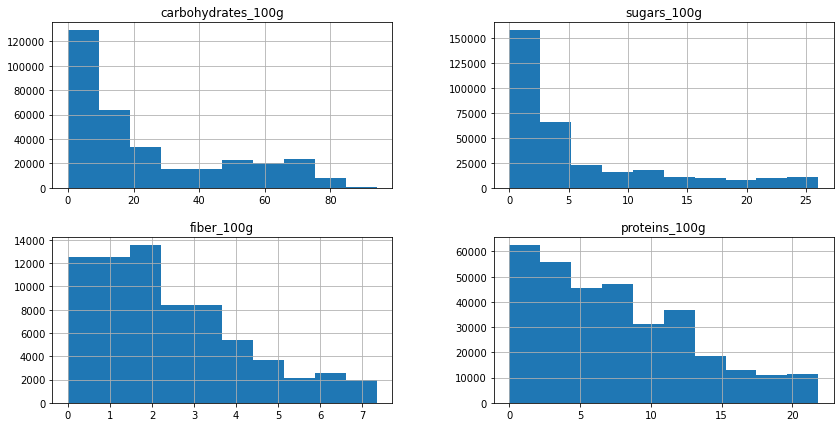

In [44]:
df_stats.loc[:,['carbohydrates_100g','sugars_100g','fiber_100g','proteins_100g']].hist(figsize=(14, 7))

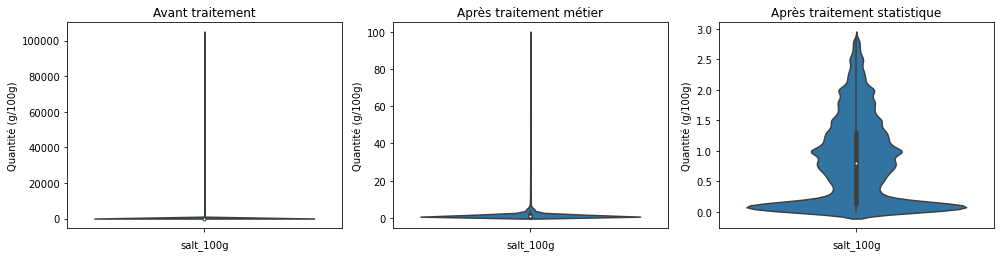

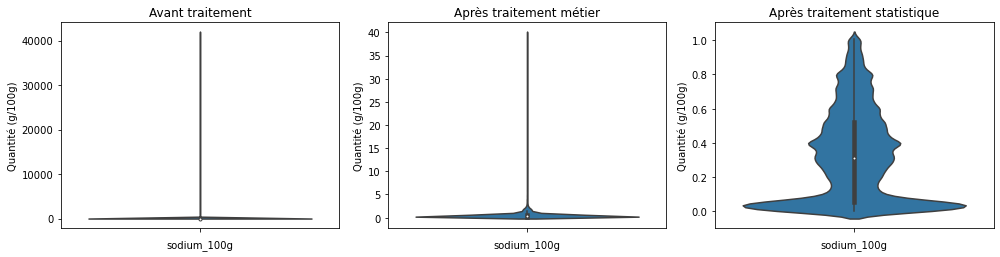

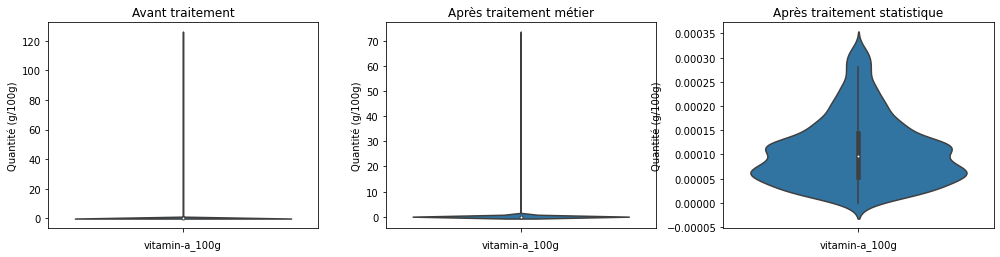

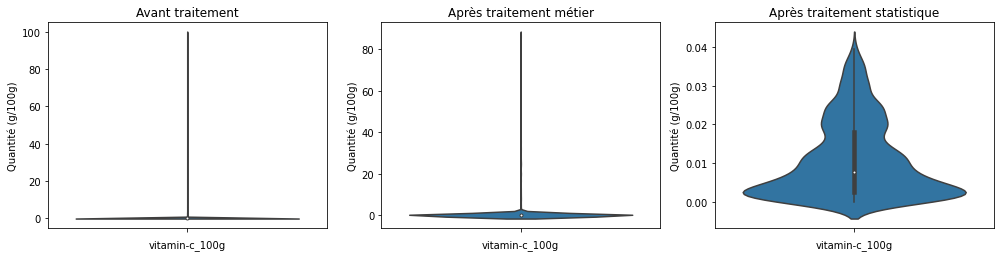

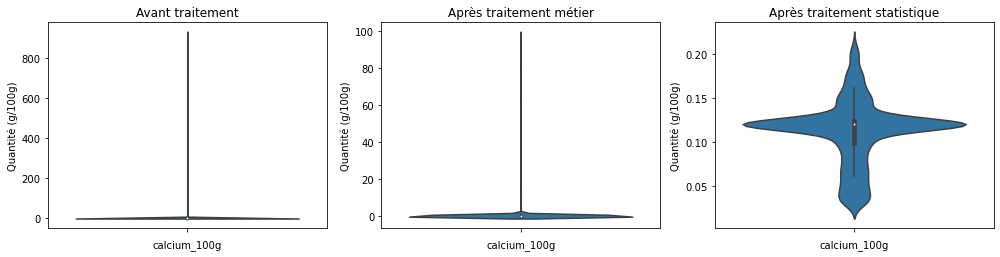

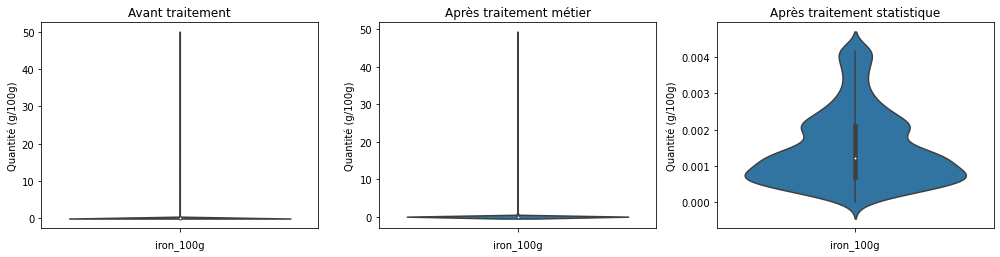

In [45]:
for col in ['salt_100g','sodium_100g','vitamin-a_100g','vitamin-c_100g','calcium_100g','iron_100g']:
    removeOutlierStats(col)
    plotTraitementViolin(col,'Quantité (g/100g)')

array([[<AxesSubplot:title={'center':'salt_100g'}>,
        <AxesSubplot:title={'center':'sodium_100g'}>],
       [<AxesSubplot:title={'center':'vitamin-a_100g'}>,
        <AxesSubplot:title={'center':'vitamin-c_100g'}>],
       [<AxesSubplot:title={'center':'calcium_100g'}>,
        <AxesSubplot:title={'center':'iron_100g'}>]], dtype=object)

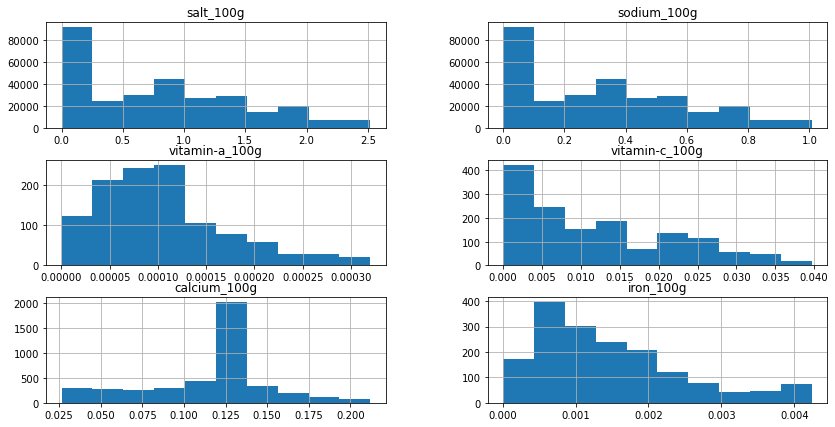

In [46]:
df_stats.loc[:,['salt_100g','sodium_100g','vitamin-a_100g','vitamin-c_100g','calcium_100g','iron_100g']].hist(figsize=(14, 7))

Après traitement il reste encore des valeurs manquantes.

<AxesSubplot:>

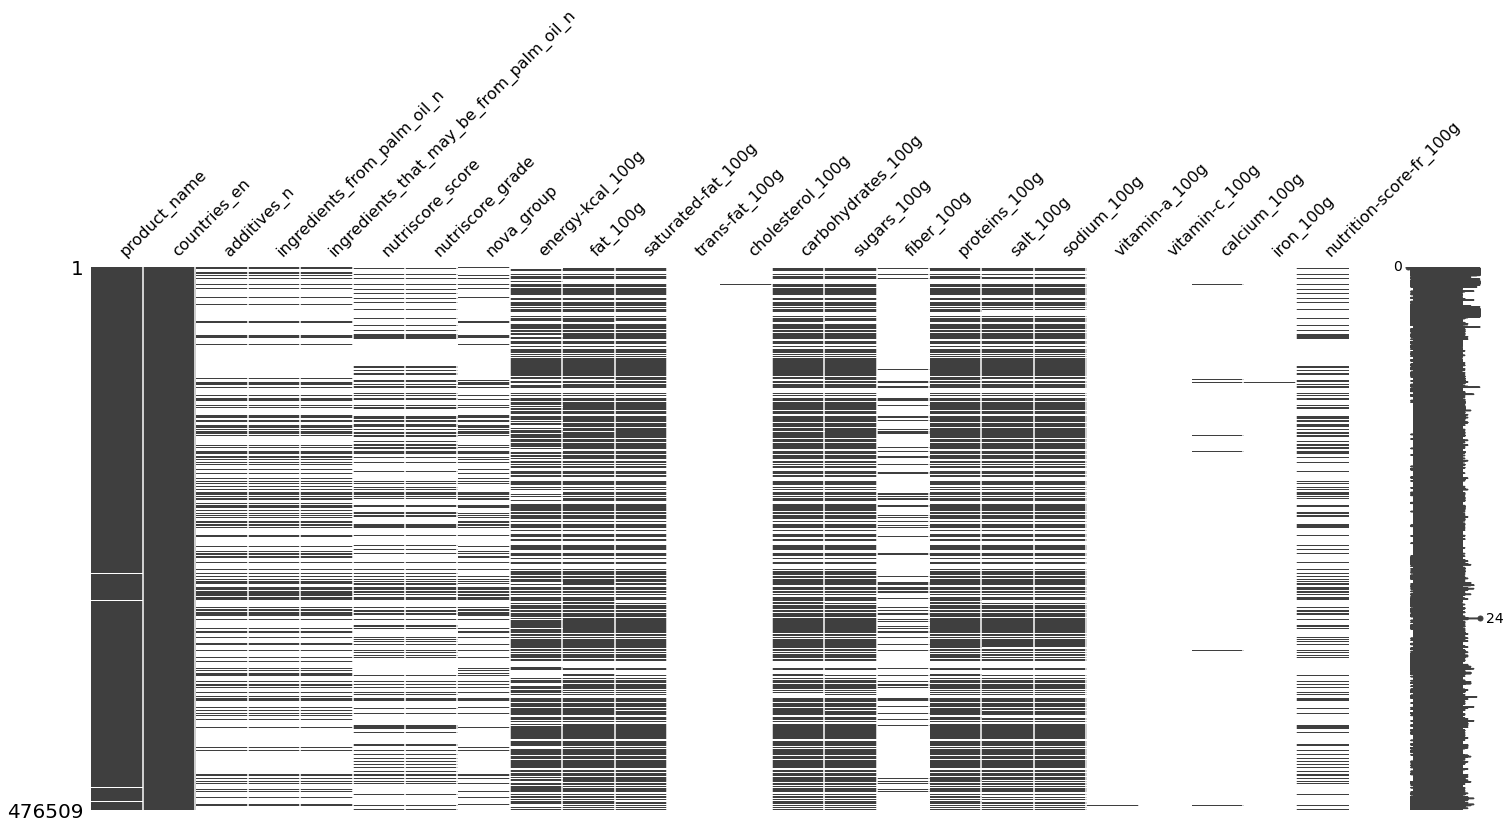

In [47]:
msno.matrix(df_stats)

Nous allons faire une sélection des lignes complètes pour les variables qui vont être utilisées dans la suite de l'étude. 

In [48]:
variable_etude = ['product_name', 'countries_en', 'additives_n', 'nutriscore_score', 'nutriscore_grade', 'nova_group', 'energy-kcal_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g','sugars_100g','proteins_100g']
df_etude = df_stats.loc[:,variable_etude]
df_etude = df_etude.dropna(axis='index', how='any')

On vérifie que l'on a suffisamment de données pour continuer l'étude. 

In [49]:
len(df_etude)

54480

Plus de 100 000 entrée pour faire l'étude du nutriscore semble suffisant. A titre indicatif on peut regarder le nombre d'entrée ayant un nutriscore renseigné.

In [50]:
print(df_stats.loc[:,'nutriscore_score'].notna().sum())

130816


In [51]:
df_etude.to_csv('data/data_apres_traitement.csv', sep=';')